# Optimization towards a Perfect-Entangler

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import weylchamber as wc
from weylchamber.visualize import WeylChamber
#from weylchamber.gates import Qmagic
from weylchamber.coordinates import from_magic

%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
krotov      0.0.1
weylchamber  0.2.1
CPython 3.6.7
IPython 7.2.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

In this example an optimization with an "unconventional" optimization target is demonstrated. Instead of a set of initial and target states or a certain target gate that should be implenented at final time, we rather just optimize for the closest perfectly entangling gate. See the following to references for detail.

* P. Watts, et al., Phys. Rev. A 91, 062306 (2015)

* M. H. Goerz, et al., Phys. Rev. A 91, 062307 (2015)

## Define parameters

In [2]:
w1 = 1.0  # qubit 1 level splitting
w2 = 2.0  # qubit 2 level splitting
J  = 0.2  # effective qubit coupling
u0 = 0.3  # initial driving strength
la = 1.1  # relative pulse coupling strength of second qubit
T  = 25.0 # final time
nt = 250  # number of time steps

## Define the Hamiltonian

The system is a two-qubit system described by the effective Hamiltonian

\begin{equation}
  \op{H}(t) = - \frac{\omega_1}{2} \op{\sigma}_{z}^{(1)} - \frac{\omega_2}{2} \op{\sigma}_{z}^{(2)} + 2 J \left(\op{\sigma}_{x}^{(1)} \op{\sigma}_{x}^{(2)} + \op{\sigma}_{y}^{(1)} \op{\sigma}_{y}^{(2)}\right) + u(t) \left(\op{\sigma}_{x}^{(1)} + \lambda \op{\sigma}_{x}^{(2)}\right),
\end{equation}
where $\omega_1$ and $\omega_2$ are the energy level splitting of both qubits, respectively, $J$ is the effective coupling strength and $u(t)$ is the control field. $\lambda$ defines the relative pulse coupling between both qubits.

In [3]:
def ham_and_states(w1=w1, w2=w2, J=J, la=la, u0=u0):
    """Two qubit Hamiltonian

    Args:
        w1 (float): energy separation of the first qubit levels
        w2 (float): energy separation of the second qubit levels
        J (float): effective coupling between both qubits
        la (float): Factor that the pulse coupling strength differs for the second qubit
        u0 (float): constant amplitude of the driving field
    """
    # local qubit Hamiltonians
    Hq1 = 0.5 * w1 * np.diag([-1,1])
    Hq2 = 0.5 * w2 * np.diag([-1,1])

    # lift Hamiltonians to joint system operators
    H0 = np.kron(Hq1, np.identity(2)) + np.kron(np.identity(2), Hq2)

    # define the interaction Hamiltonian
    sig_x = np.array([[0,1],[1,0]])
    sig_y = np.array([[0,-1j],[1j,0]])
    Hint = 2*J*(np.kron(sig_x, sig_x) + np.kron(sig_y, sig_y))
    H0 = H0 + Hint

    # define the drive Hamiltonian
    H1 = np.kron(np.array([[0,1],[1,0]]), np.identity(2))\
    + la*np.kron(np.identity(2), np.array([[0,1],[1,0]]))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0)
    H1 = qutip.Qobj(H1)

    # canonical basis
    # TODO: you can instantiate these directly with `qutip.ket`!
    psi_00 = qutip.Qobj(np.kron(np.array([1,0]), np.array([1,0])))
    psi_01 = qutip.Qobj(np.kron(np.array([1,0]), np.array([0,1])))
    psi_10 = qutip.Qobj(np.kron(np.array([0,1]), np.array([1,0])))
    psi_11 = qutip.Qobj(np.kron(np.array([0,1]), np.array([0,1])))

    # define guess field
    eps0 = lambda t, args: u0
    return ([H0, [H1, eps0]], psi_00, psi_01, psi_10, psi_11)

H, psi_00, psi_01, psi_10, psi_11= ham_and_states(
    w1=w1, w2=w2, J=J, la=la, u0=u0)

For the optimization later on, we need to use the Bell basis

**TODO: Don't do that. The notebook should only use the canonical basis. `gate_objectives` will handle this automatically if `gate='PE'` is passed**

\begin{equation}
  \ket{\Phi^{+}} = \frac{\Ket{00} + \Ket{11}}{\sqrt{2}},
  \quad
  \ket{\Psi^{+}} = i \frac{\Ket{01} + \Ket{10}}{\sqrt{2}},
  \quad
  \ket{\Psi^{-}} = \frac{\Ket{01} - \Ket{10}}{\sqrt{2}},
  \quad
  \ket{\Phi^{-}} = i \frac{\Ket{00} - \Ket{11}}{\sqrt{2}},
\end{equation}

instead of the canonical basis $\ket{00}, \ket{01}, \ket{10}, \ket{11}$.

In [4]:
bell_1 = qutip.Qobj((psi_00+psi_11)/np.sqrt(2))
bell_2 = qutip.Qobj(1j*(psi_01+psi_10)/np.sqrt(2))
bell_3 = qutip.Qobj((psi_01-psi_10)/np.sqrt(2))
bell_4 = qutip.Qobj(1j*(psi_00-psi_11)/np.sqrt(2))

In [5]:
proj_00 = psi_00 * psi_00.dag()
proj_01 = psi_01 * psi_01.dag()
proj_10 = psi_10 * psi_10.dag()
proj_11 = psi_11 * psi_11.dag()

## Define the optimization target

The time grid is given by `nt` equidistant
time steps between $t=0$ and $t=T$.

In [6]:
tlist = np.linspace(0, T, nt)

In order to specify the closest perfectly entangling gate as optimization target, we temporarily pass CNOT as target gate, although it will not be used within the optimization. Note that for using the perfect-entangler functional, the two-qubit basis and the implemented gates must be given by the Bell basis.

**TODO: pass `gate='PE'` instead of CNOT**

**TODO: "implemented gates must be given in the Bell basis" is confusing.**

In [7]:
gate = qutip.gates.cnot()
objectives = krotov.gate_objectives(
    basis_states=[bell_1,bell_2,bell_3,bell_4], gate=gate, H=H
)

Furthermore, we define the shape function $S(t)$, which we use in order to
ensure a smooth switch on and off in the beginning and end.

In [8]:
def S(t):
    """Shape function for the field update"""
    #return krotov.shapes.flattop(t, t_start=0, t_stop=T, t_rise=T/10, t_fall=T/10, func='sinsq')
    return krotov.shapes.one_shape(t)

**TODO: actually use the pulse shape**

**TODO: try to find a guess amplitude that minimized concurrence (you can use simplex optimization)**

Although the shape function $S(t)$ has by default nothing to do with the initial shape of the guess field, we also still shape the guess field with the defined $S(t)$.

In [9]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: eps0(t, args)*S(t)
    return eps0_shaped

H[1][1] = shape_field(H[1][1])

Before heading to the optimization, we still have to choose `lambda_a`, which defines the control update magnitude in each iteration, and assign $S(t)$ to be used as shape function.

In [10]:
pulse_options = {
    H[1][1]: krotov.PulseOptions(lambda_a=1.0e2, shape=S)
}

## Simulate dynamics of the guess field

In [11]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

The following plot shows the guess field $u_{0}(t)$.

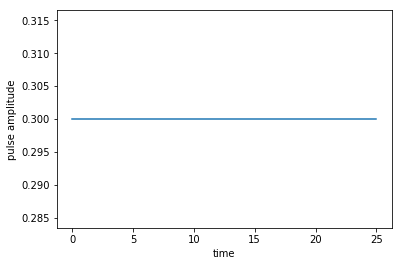

In [12]:
plot_pulse(H[1][1], tlist)

Moreover, before optimization, we solve the equation of motion with the guess field $u_{0}(t)$.

In [13]:
guess_dynamics = [
    objectives[x].mesolve(
        tlist, e_ops=[proj_00, proj_01, proj_10, proj_11]
    )
    for x in [0,1,2,3]
]

In [14]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='00')
    ax.plot(result.times, result.expect[1], label='01')
    ax.plot(result.times, result.expect[2], label='10')
    ax.plot(result.times, result.expect[3], label='11')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

The following plots show the population dynamics of the canonical basis for the initial state being on of those four states.

**TODO: you're showing the Bell basis, not the canonical basis, but it should be canonical basis. I don't know if these dynamics are very instructive. Might be better to plot the path the Weyl chamber or concurrence over time**

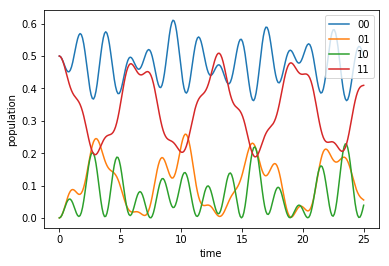

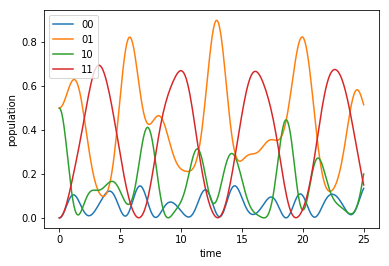

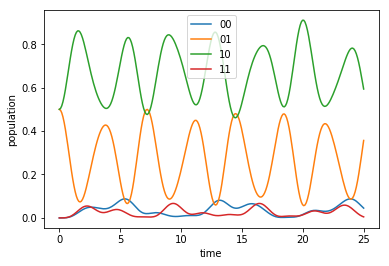

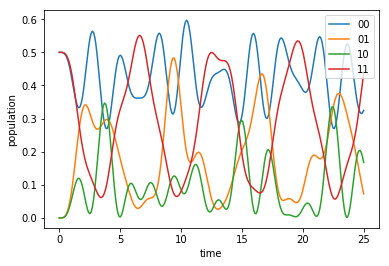

In [15]:
plot_population(guess_dynamics[0])
plot_population(guess_dynamics[1])
plot_population(guess_dynamics[2])
plot_population(guess_dynamics[3])

## Optimize

Our optimization target is the closest perfectly entangling gate, quantified by the perfect-entangler functional

\begin{equation}
  F_{PE} = g_3 \sqrt{g_1^2 + g_2^2} - g_1,
\end{equation}

where $g_1, g_2, g_3$ are the local invariants of the implemented gate, which uniquely identify its non-local content. As an alternative, one can also use the Weyl coordinates $c_1, c_2, c_3$ to plot the gate in the Weyl chamber. The perfectly entangling gates lie within a polyhedron within the general Weyl chamber and $F_{PE}$ becomes zero exactly at its boundaries.

In order to get feedback from the optimization, we define `print_fidelity`, which is called after each OCT step and which calculates $F_{PE}$ and the gate concurrence (as an alternative measure for the entangling power of quantum gates).

In [16]:
def print_fidelity(**args):
    basis = [objectives[i].initial_state for i in [0,1,2,3]]
    states = [args['fw_states_T'][i] for i in [0,1,2,3]]
    U = wc.gates.gate(basis, states)
    c1,c2,c3 = wc.coordinates.c1c2c3(from_magic(U))
    g1,g2,g3 = wc.local_invariants.g1g2g3_from_c1c2c3(c1,c2,c3)
    conc = wc.perfect_entanglers.concurrence(c1, c2, c3)
    F_PE = wc.perfect_entanglers.F_PE(g1, g2, g3)
    print("Iteration %d: \tF_PE = %f \tgate conc. = %f"
          % (args['iteration'], F_PE, conc))
    return F_PE, [c1, c2, c3]

Since Krotov's method needs to know how to calculate the so-called co-states, we must provide a callable function called `chi_constructor` to the optimization function `optimize_pulses`. This function returns

\begin{equation}
  \ket{\chi_{i}} = \frac{\partial F_{PE}}{\partial \bra{\phi_i}} \Bigg|_{\ket{\phi_{i}(T)}}
\end{equation}

for all $i$ and with $\ket{\phi_i(T)}$ a set of forward propagated Bell basis states. The required function is implemented in the package `weylchamber` and taken from there.

In [17]:
chi_constructor = wc.perfect_entanglers.make_PE_krotov_chi_constructor(
    [psi_00,psi_01,psi_10,psi_11]
)

AttributeError: module 'weylchamber.perfect_entanglers' has no attribute 'make_PE_krotov_chi_constructor'

In the following, we carry out the optimization and save the Weyl coordinates $c_1, c_2, c_3$ from each iteration

In [18]:
oct_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chi_constructor,
    info_hook=print_fidelity,
    check_convergence=None,
    iter_stop=15,
)

c1c2c3 = [
    oct_result.info_vals[i][1] for i in range(len(oct_result.iters))
]

NameError: name 'chi_constructor' is not defined

The following plots the path of the quantum gate within the Weyl chamber as a function of the iterations.

In [19]:
w = WeylChamber();
for i in range(len(oct_result.iters)):
    w.add_point(c1c2c3[i][0],c1c2c3[i][1],c1c2c3[i][2])
w.plot()

NameError: name 'oct_result' is not defined

## Simulate dynamics of the optimized field

Finally, we plot the optimized field and the population dynamics generated by it.

In [20]:
plot_pulse(oct_result.optimized_controls[0], tlist)

NameError: name 'oct_result' is not defined

In [21]:
opt_dynamics = [oct_result.optimized_objectives[x].mesolve(
    tlist, e_ops=[proj_00, proj_01, proj_10, proj_11]) for x in [0,1,2,3]]

NameError: name 'oct_result' is not defined

In [22]:
plot_population(opt_dynamics[0])
plot_population(opt_dynamics[1])
plot_population(opt_dynamics[2])
plot_population(opt_dynamics[3])

NameError: name 'opt_dynamics' is not defined